## HW3: Decision Tree and Random Forest
In hw3, you need to implement decision tree and random forest by using only numpy, then train your implemented model by the provided dataset and test the performance with testing data

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling sklearn.tree.DecisionTreeClassifier

In [1]:
!pip install sklearn

## Load data

In [21]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
import math
import random
import matplotlib.pyplot as plt
import time

In [3]:
data = load_breast_cancer()
feature_names = data['feature_names']
print(feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [4]:
x_train = pd.read_csv("x_train.csv")
y_train = pd.read_csv("y_train.csv")
x_test = pd.read_csv("x_test.csv")
y_test = pd.read_csv("y_test.csv")

In [5]:
a = x_train.values.tolist()
#a = np.array(x_train)
b = np.array(y_train)
c = x_test.values.tolist()
#c = np.array(x_test)
d = np.array(y_test)

0.1076

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from page 666 on the textbook

In [6]:
def gini(sequence):
    if len(sequence) == 0:
        return 0
    
    n = len(sequence)
    p0, p1, p2 = 0, 0, 0
    for kind in sequence:
        if kind == 0:
            p0 += 1
        elif kind == 1:
            p1 += 1
        elif kind == 2:
            p2 += 1
            
    p0 /= n
    p1 /= n
    p2 /= n
    impurity = 1 - p0**2 - p1**2 - p2**2
    return impurity

def entropy(sequence):
    if len(sequence) == 0:
        return 0
    
    n = len(sequence)
    p0, p1, p2 = 0, 0, 0
    for kind in sequence:
        if kind == 0:
            p0 += 1
        elif kind == 1:
            p1 += 1
        elif kind == 2:
            p2 += 1
    
    p1 /= n
    if p2 > 0:
        p2 /= n
        impurity = -(p1*math.log2(p1) + p2*math.log2(p2))
    else:
        p0 /= n
        if p0 == 0 or p1 == 0:
            return 1
        impurity = -(p0*math.log2(p0) + p1*math.log2(p1))
    return impurity

In [7]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [8]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [9]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006402


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the test data. You should implement two arguments for the Decision Tree algorithm
1. **Criterion**: The function to measure the quality of a split. Your model should support “gini” for the Gini impurity and “entropy” for the information gain. 
2. **Max_depth**: The maximum depth of the tree. If Max_depth=None, then nodes are expanded until all leaves are pure. Max_depth=1 equals to split data once


In [10]:
features = x_train.columns

In [11]:
class Question:
    def __init__(self, feature, pivot):
        self.feature = feature
        self.pivot = pivot
        
def partition(data, res, feature, pivot):
    # true: left, false: right
    left, right, left_res, right_res = [], [], [], []
    for i in range(len(data)):
        if data[i][feature] >= pivot:
            left.append(data[i][:])
            left_res.append(res[i])
        else:
            right.append(data[i][:])
            right_res.append(res[i])
            
    return left, right, left_res, right_res

In [12]:
def info_gain(parent, left, right, criterion):
    p = float(len(left)) / (len(left) + len(right))
    if criterion == 'gini':
        return gini(parent) - p * gini(left) - (1 - p) * gini(right)
    elif criterion == 'entropy':
        return entropy(parent) - p * entropy(left) - (1 - p) * entropy(right)
    
def best_split(data, res, criterion):
    best_gain = 0
    question = None
    left, right, left_res, right_res = [], [], [], []
    for feature in range(len(features)):
        for i in range(len(data)):
            left, right, left_res, right_res = partition(data, res, feature, data[i][feature])
            gain = info_gain(res, left_res, right_res, criterion)
            if gain > best_gain:
                best_gain = gain
                question = Question(feature, data[i][feature])
                
    return question

def split(data, res, criterion, feats):
    best_gain = 0
    question = None
    left, right, left_res, right_res = [], [], [], []
    for feature in feats:
        for i in range(len(data)):
            left, right, left_res, right_res = partition(data, res, feature, data[i][feature])
            gain = info_gain(res, left_res, right_res, criterion)
            if gain > best_gain:
                best_gain = gain
                question = Question(feature, data[i][feature])
    
    return question

In [13]:
class Node:
    def __init__(self, data, res, criterion, depth, question):
        self.data = data
        self.res = res
        self.criterion = criterion
        self.depth = depth
        self.question = question
        self.isLeaf = False
        self.left = None
        self.right = None
        
class DecisionTree:
    def __init__(self, criterion, max_depth=None, data=a, res=b):
        self.criterion = criterion
        self.max_depth = max_depth
        self.root = Node(data=data, res=res, criterion=criterion, depth=0, question=None)
        self.feat_impo = np.zeros(30)
        #self.build_tree(self.root)
    
    def build_tree(self, current):
        if self.max_depth != None:
            if current.depth+1 > self.max_depth:
                return
            else:
                current.left = Node(data=None, res=None, criterion=self.criterion, depth=current.depth+1, question=None)
                current.right = Node(data=None, res=None, criterion=self.criterion, depth=current.depth+1, question=None)
                current.question = best_split(current.data, current.res, self.criterion)
                if current.question == None:
                    current.isLeaf = True
                    current.left = None
                    current.right = None
                else:
                    current.left.data, current.right.data, current.left.res, current.right.res = partition(current.data, current.res, current.question.feature, current.question.pivot)
                    self.feat_impo[current.question.feature] += 1
            if not current.isLeaf:
                self.build_tree(current.left)
                self.build_tree(current.right)
            else:
                return
                
    def build_rand(self, current, feats):
        current.left = Node(data=None, res=None, criterion=current.criterion, depth=current.depth+1, question=None)
        current.right = Node(data=None, res=None, criterion=current.criterion, depth=current.depth+1, question=None)
        current.question = split(current.data, current.res, current.criterion, feats)
        if current.question == None:
            current.isLeaf = True
            current.left = None
            current.right = None
        else:
            current.left.data, current.right.data, current.left.res, current.right.res = partition(current.data, current.res, current.question.feature, current.question.pivot)
        if not current.isLeaf:
            self.build_rand(current.left, feats)
            self.build_rand(current.right, feats)
        else:
            return
                    
    def predict(self, data):
        pred = []
        for i in range(len(data)):
            current = self.root
            while current.question != None:
                if data[i][current.question.feature] >= current.question.pivot:
                    current = current.left
                else:
                    current = current.right
            p0, p1 = 0, 0
            for result in current.res:
                if result == 0:
                    p0 += 1
                else:
                    p1 += 1
            if p0 >= p1:
                pred.append(0)
            else:
                pred.append(1)
        return pred

### Question 2.1
Using Criterion=‘gini’, showing the accuracy score of test data by Max_depth=3 and Max_depth=10, respectively.


In [14]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth3.build_tree(clf_depth3.root)
clf_depth3_pred = clf_depth3.predict(c)
print("clf_depth3 accuracy score: {}".format(accuracy_score(d, clf_depth3_pred)))

clf_depth3 accuracy score: 0.9300699300699301


In [15]:
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)
clf_depth10.build_tree(clf_depth10.root)
clf_depth10_pred = clf_depth10.predict(c)
print("clf_depth10 accuracy score: {}".format(accuracy_score(d, clf_depth10_pred)))

clf_depth10 accuracy score: 0.9300699300699301


### Question 2.2
Using Max_depth=3, showing the accuracy score of test data by Criterion=‘gini’ and Criterion=’entropy’, respectively.


In [16]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_gini.build_tree(clf_gini.root)
clf_gini_pred = clf_gini.predict(c)
print("clf_gini accuracy score: {}".format(accuracy_score(d, clf_gini_pred)))

clf_gini accuracy score: 0.9300699300699301


In [17]:
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
clf_entropy.build_tree(clf_entropy.root)
clf_entropy_pred = clf_entropy.predict(c)
print("clf_entroy accuracy score: {}".format(accuracy_score(d, clf_entropy_pred)))

clf_entroy accuracy score: 0.9300699300699301


- Note: All of your accuracy scores should over 0.9
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the feature counts for building tree without normalize the importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

<BarContainer object of 30 artists>

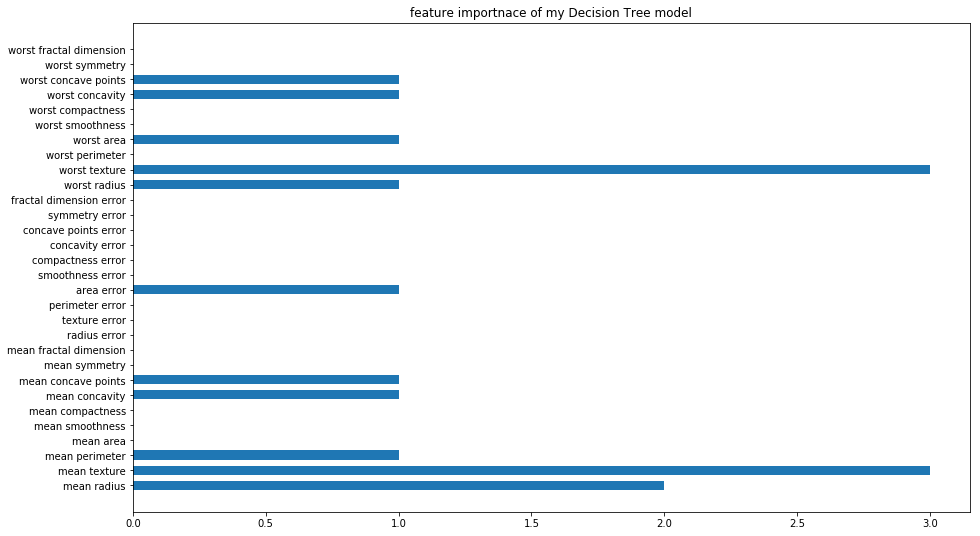

In [18]:
importance = clf_depth10.feat_impo
#print(importance)
x = np.array(features)
plt.figure(figsize = (15,9))
plt.title('feature importnace of my Decision Tree model')

plt.barh(x, importance, height=0.6)

## Question 4
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement two arguments for the Random Forest.

1. **N_estimators**: The number of trees in the forest. 
2. **Max_features**: The number of random select features to consider when looking for the best split
3. **Bootstrap**: Whether bootstrap samples are used when building tree


In [19]:
class RandomForest():
    def __init__(self, n_estimators, max_features, bootstrap=True, criterion='gini', max_depth=None):
        self.trees = []
        self.num_tree = n_estimators
        self.max_features = int(max_features)
        self.boot = bootstrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.build_forest()
    
    def build_forest(self):
        _space = np.linspace(0, len(a)-1, len(a), dtype='int')
        for case in range(self.num_tree):
            sample_rows = []
            sample_data = []
            sample_res = []
            if self.boot:
                for i in range(len(a)):
                    sample_rows.append(random.choice(_space))

                for row in sample_rows:
                    sample_data.append(a[row][:])
                    sample_res.append(b[row])
                    
            else:
                for i in range(len(a)):
                    sample_rows.append(a[i][:])
                    sample_res.append(b[i])
            
            feat_l = np.linspace(0, len(features)-1, len(features), dtype='int')
            feats = random.sample(list(feat_l), self.max_features)
            tree = DecisionTree(criterion=self.criterion, max_depth=self.max_depth, data=sample_data, res=sample_res)
            tree.build_rand(tree.root, feats=feats)
            self.trees.append(tree)
            
    def predict(self, data):
        pred_all = []
        pred = []
        for vote in range(self.num_tree):
            pred_all.append(self.trees[vote].predict(data))
        
        for i in range(len(data)):
            _0, _1 = 0, 0
            for j in range(self.num_tree):
                if pred_all[j][i] == 0:
                    _0 += 1
                else:
                    _1 += 1
                    
            if _0 >= _1:
                pred.append(0)
            else:
                pred.append(1)
                
        return pred

### Question 4.1
Using Criterion=‘gini’, Max_depth=None, Max_features=sqrt(n_features), showing the accuracy score of test data by n_estimators=10 and n_estimators=100, respectively.


In [20]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_10tree_pred = clf_10tree.predict(c)
print("accuracy score: {}".format(accuracy_score(d, clf_10tree_pred)))

accuracy score: 0.958041958041958


In [26]:
tstart = time.time()
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]))
clf_100tree_pred = clf_100tree.predict(c)
print("accuracy score: {}".format(accuracy_score(d, clf_100tree_pred)))
tend = time.time()
print(tend - tstart)

accuracy score: 0.9300699300699301
-1125.2552237510681


### Question 4.2
Using Criterion=‘gini’, Max_depth=None, N_estimators=10, showing the accuracy score of test data by Max_features=sqrt(n_features) and Max_features=n_features, respectively.


In [27]:
clf_all_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_all_features_pred = clf_all_features.predict(c)
print("accuracy score: {}".format(accuracy_score(d, clf_all_features_pred)))

accuracy score: 0.9370629370629371


In [ ]:
tstart = time.time()
clf_random_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])
clf_random_features_pred = clf_random_features.predict(c)
print("accuracy score: {}".format(accuracy_score(d, clf_random_features_pred)))
tend = time.time()
print(tend - tstart)

- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 